# Energy calibration
New notebook to compute energy calibration
Uses the energy in MIP from Bruno's ntuples (made by TestBeamReconstruction/DataProcessing), applies dE/dx weights then fits the distribution

In [3]:
%load_ext autoreload
%autoreload 1
import sys
from collections import namedtuple
import numpy as np
from uncertainties import ufloat, unumpy
import uproot
import hist
import awkward as ak
import uncertainties
import scipy
from scipy.stats import linregress
from tqdm.auto import tqdm
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

sys.path.append("..")

from hists.parameters import beamEnergies, dEdx_weights, synchrotronBeamEnergiesMap
%aimport energy_resolution.sigma_over_e
from energy_resolution.sigma_over_e import SigmaOverEComputations, SigmaMuResult
from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
from ntupleReaders.bruno_ntuple_reader import BrunoNtupleReader
#from fit import HistogramEstimates

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def makeHistDict():
    return {beamEnergy : hist.Hist(hist.axis.Regular(bins=500, start=synchrotronBeamEnergiesMap[beamEnergy]*0.6, stop=synchrotronBeamEnergiesMap[beamEnergy]*1.3, name="energy_per_event", label="Energy per event (GeV)"))
        for beamEnergy in beamEnergies}

def applydEdx(ar:ak.Array):
    dedx_ak = ak.Array([0] + list(dEdx_weights.values()))
    counts = ak.num(ar.ce_clean_layer)
    dedx_perHit = ak.unflatten(dedx_ak[ak.flatten(ar.ce_clean_layer)], counts)
    return ar.ce_clean_energy * dedx_perHit

def loadArrayIntoHists(ar:ak.Array, h_dict:dict[int, hist.Hist], useEnergyInMips=True):
    if useEnergyInMips:
        energies = ak.sum(applydEdx(ar), axis=-1)*1e-3 # convert MeV to GeV
    else:
        energies = ak.sum(ar.ce_clean_energy_MeV, axis=-1)*1e-3
    for beamEnergy in beamEnergies:
        cut_ar = ar.beamEnergy == beamEnergy
        if ak.any(cut_ar):
            h_dict[beamEnergy].fill(energies[cut_ar])

def loadAllTreesIntoHists(reader:BrunoNtupleReader, useEnergyInMips=True, **iterate_kwargs) -> dict[int, hist.Hist]:
    h_dict = makeHistDict()
    for array in tqdm(uproot.iterate([filename + ":relevant_branches" for filename in reader.listOfNtuplesPaths], step_size="500MB",
                filter_name=["ce_clean_energy", "ce_clean_energy_MeV", "ce_clean_layer", "beamEnergy"], **iterate_kwargs), total=len(reader.listOfNtuplesPaths)):
        loadArrayIntoHists(array, h_dict, useEnergyInMips=useEnergyInMips)
    return h_dict

def makeAllComputations(reader:BrunoNtupleReader, useEnergyInMips=True) -> SigmaOverEComputations:
    h_dict = loadAllTreesIntoHists(reader, useEnergyInMips=useEnergyInMips)
    comp = SigmaOverEComputations()
    comp.compute(h_dict, multiprocess="forkserver")
    return h_dict, comp

In [11]:
#reader = BrunoNtupleReader("v7", "data")
h_dict_data, comp_data = makeAllComputations(BrunoNtupleReader("v7", "data"), useEnergyInMips=False)

#h_dict_sim, comp_sim = makeAllComputations(BrunoNtupleReader("v7", "sim_proton_v46_patchMIP"), useEnergyInMips=False)
h_dict_sim_raw, comp_sim_raw = makeAllComputations(BrunoNtupleReader("v7", "sim_proton_v46_patchMIP"), useEnergyInMips=True)

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
h_dict_data_raw, comp_data_raw = makeAllComputations(BrunoNtupleReader("v7", "data"), useEnergyInMips=True)

  0%|          | 0/116 [00:00<?, ?it/s]

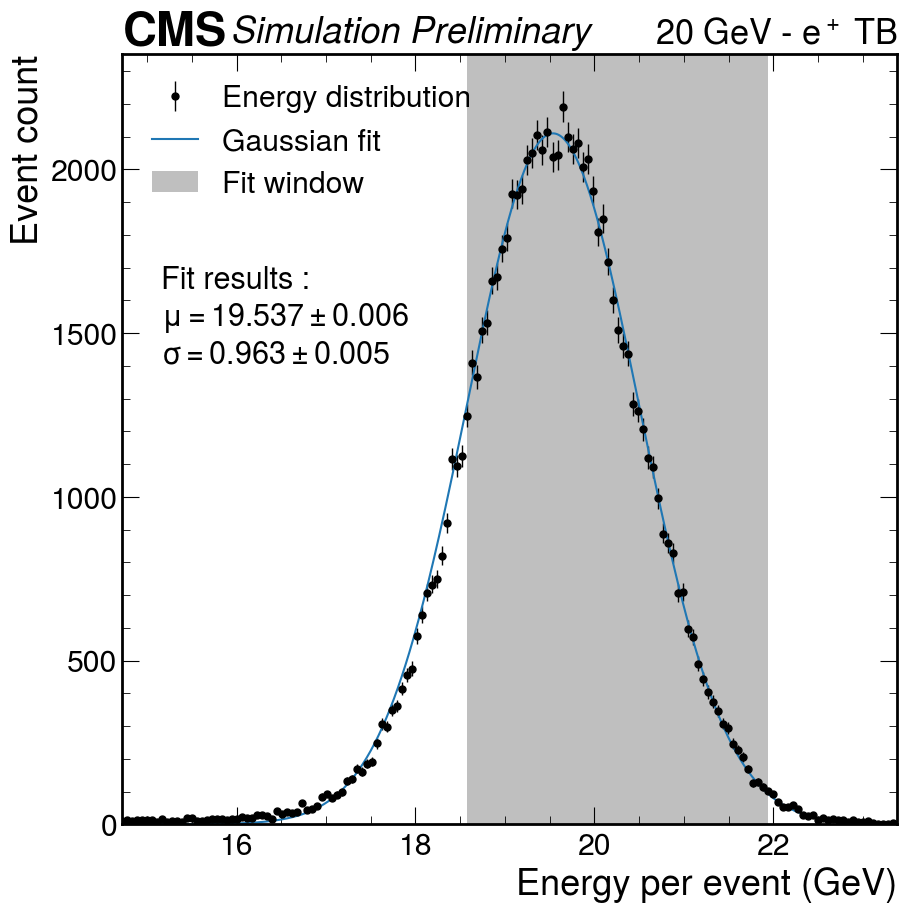

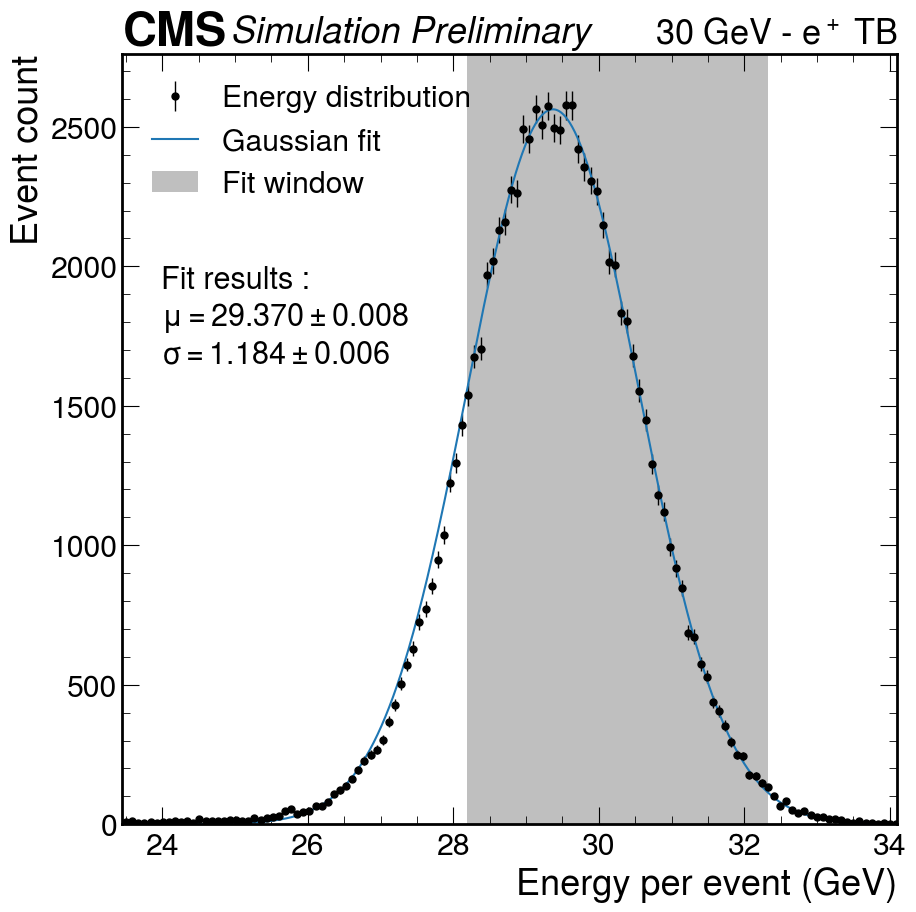

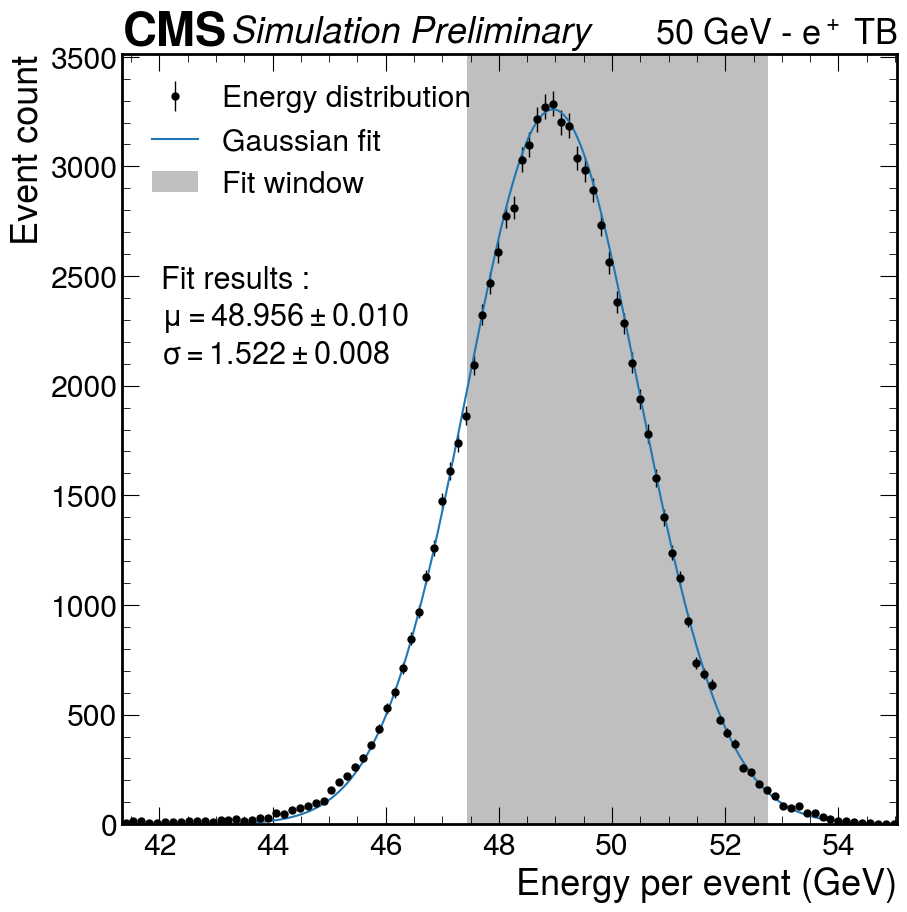

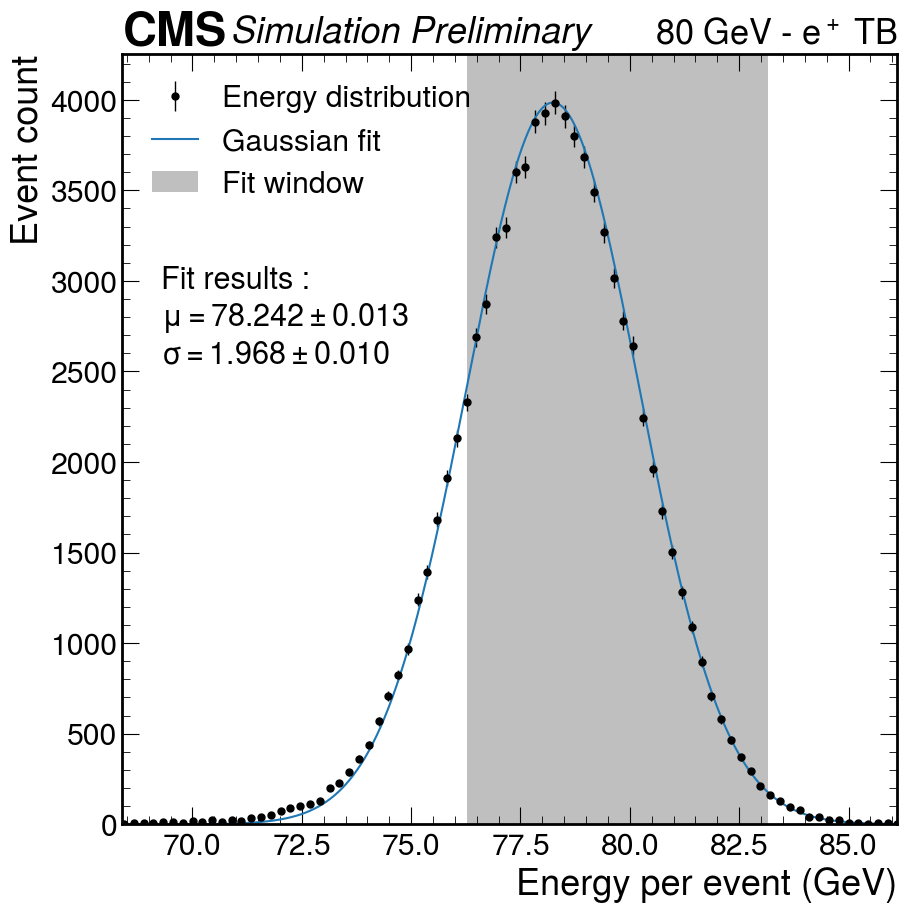

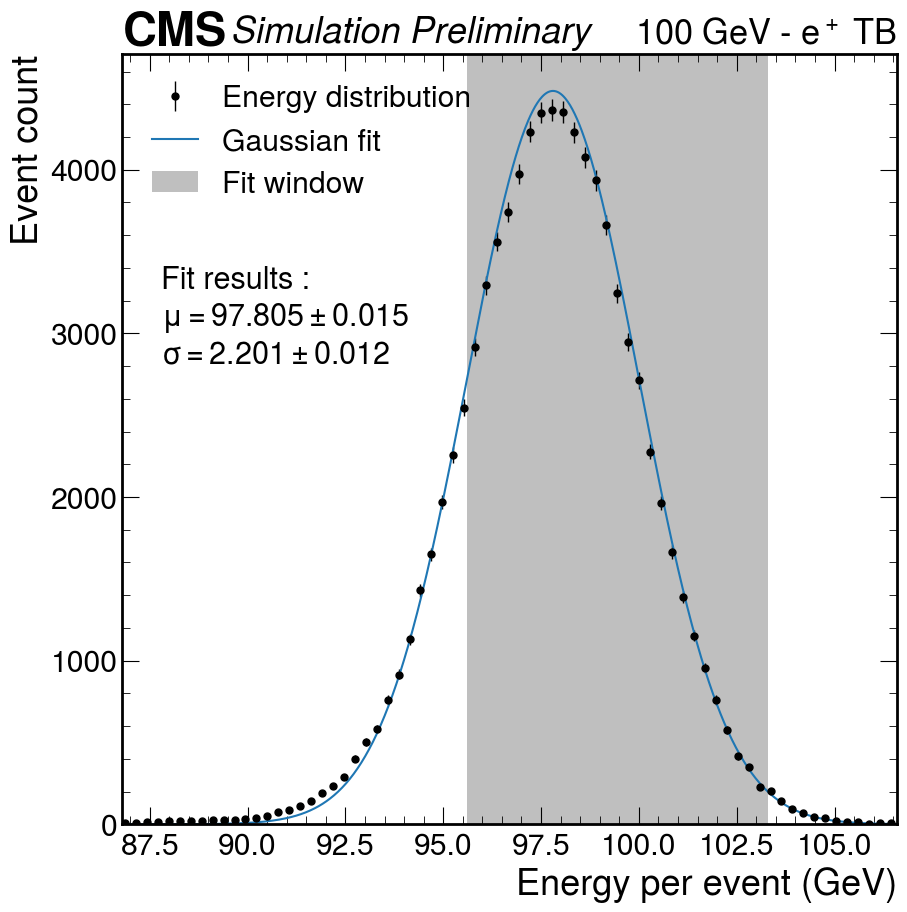

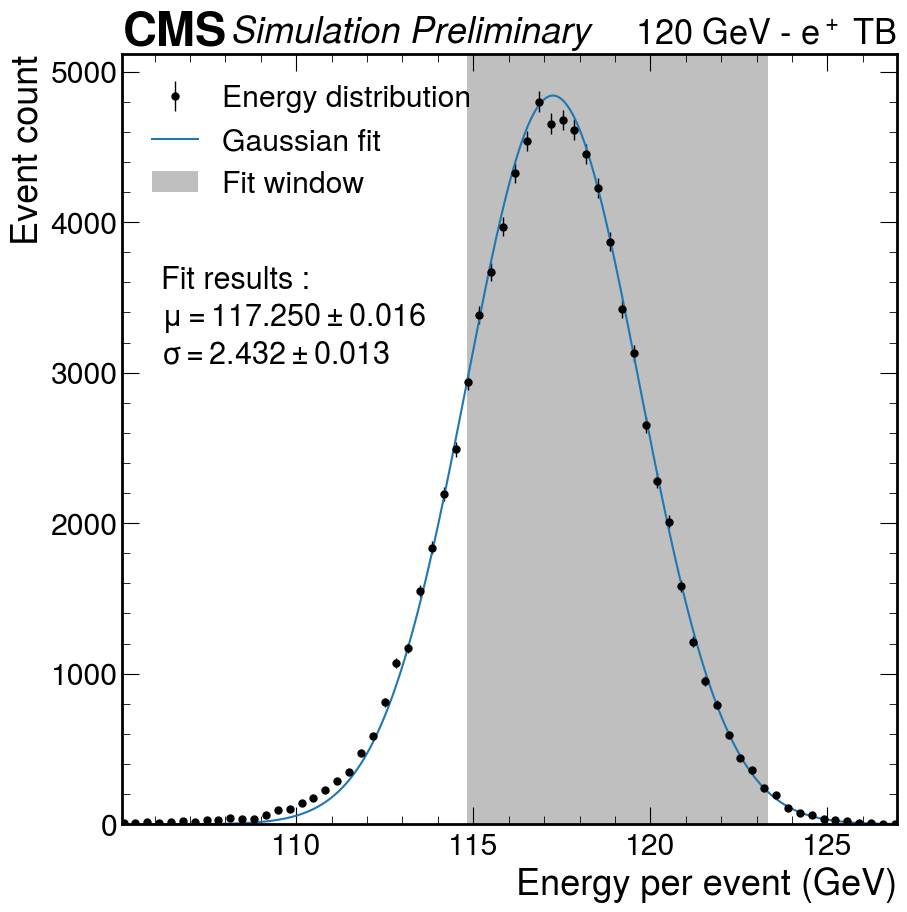

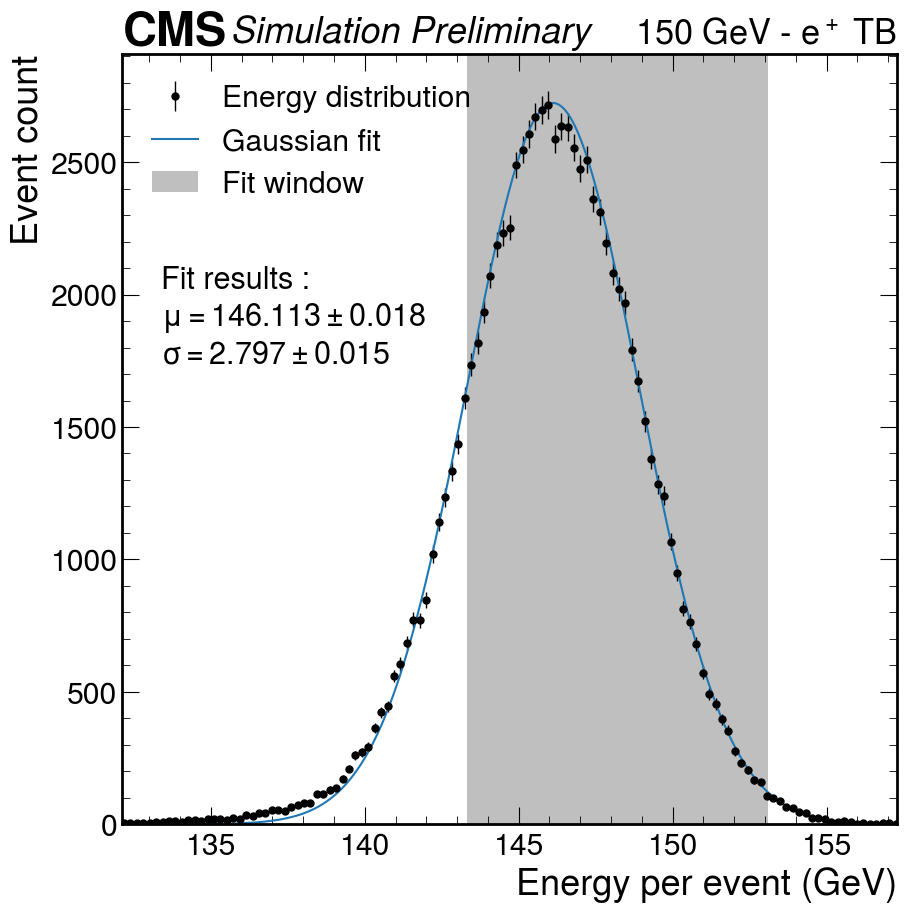

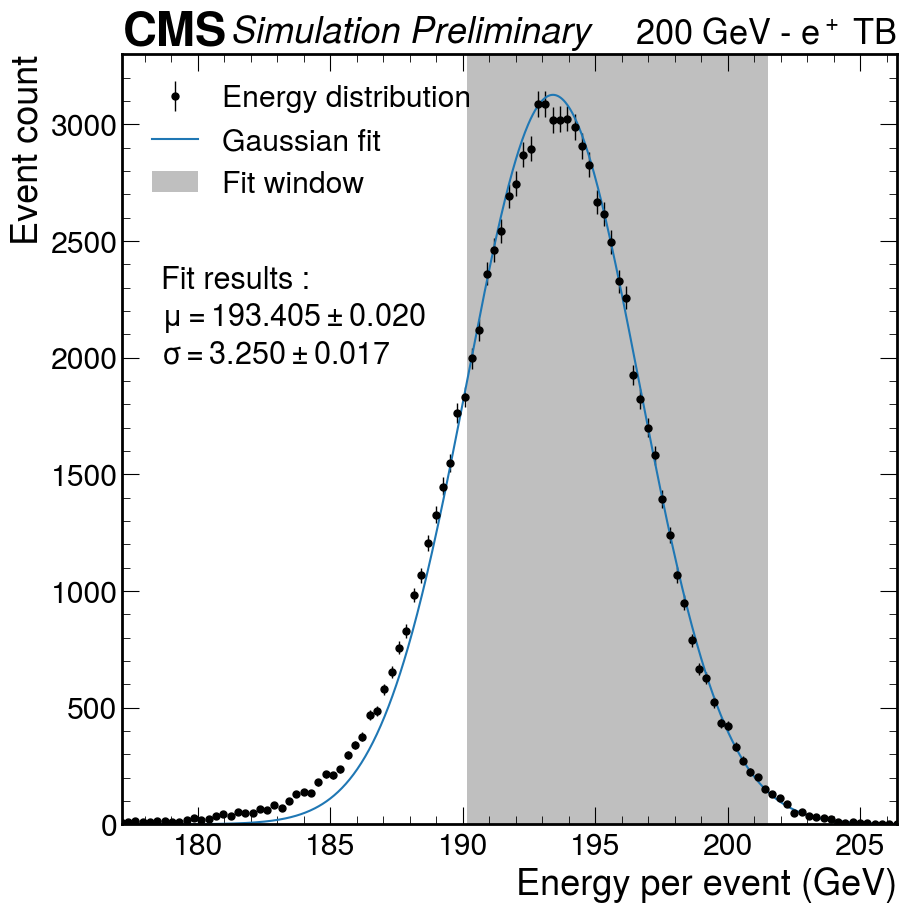

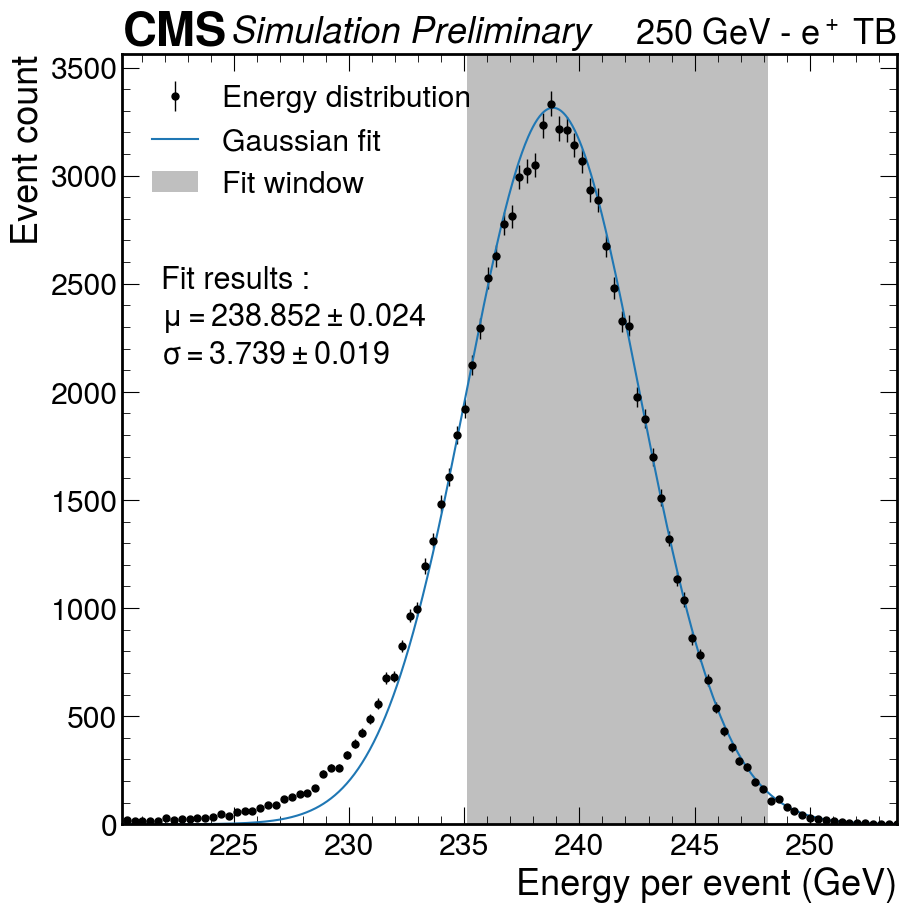

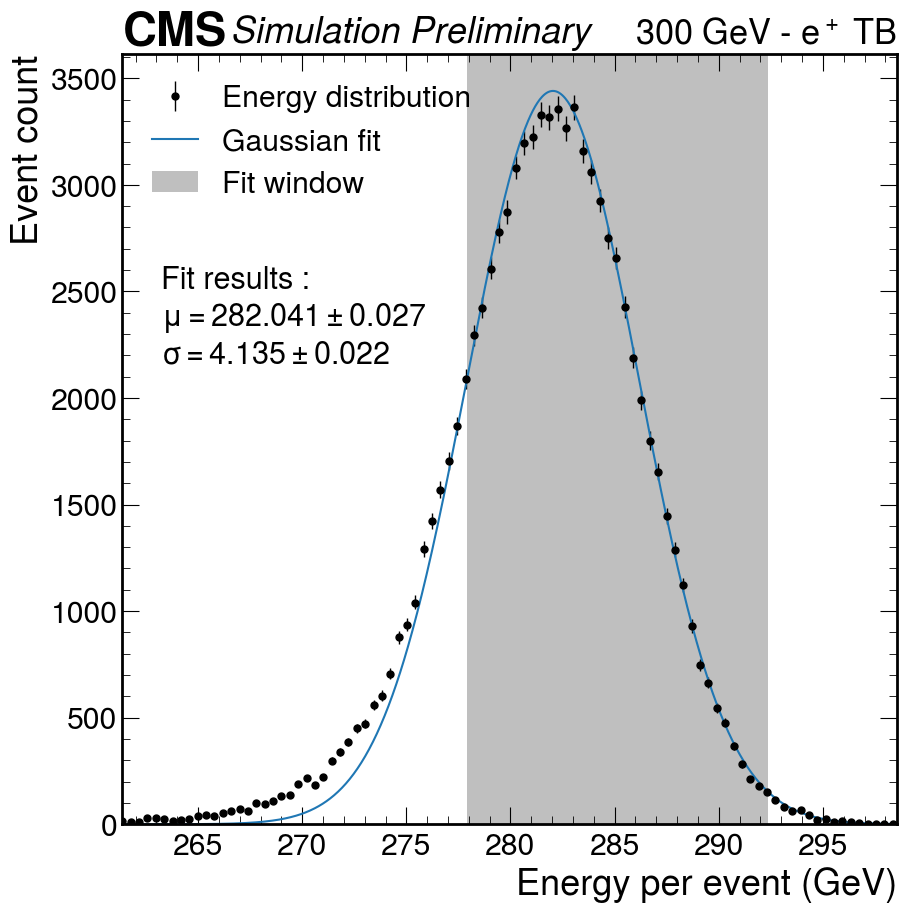

In [5]:
for beamEnergy in beamEnergies:
    f = comp_sim.plotFitResult(beamEnergy, rebin=1 if beamEnergy >= 150 else 2, sim=True)
    f.savefig(f"energyDistribution-{beamEnergy}.pdf", bbox_inches="tight")

In [8]:
def makeDiffXY(fitResults:dict[int, SigmaMuResult]):
    x = []
    y = []
    for beamEnergy, sigmaMuResult in fitResults.items():
        x.append(synchrotronBeamEnergiesMap[beamEnergy])
        y.append(sigmaMuResult.mu.nominal_value-synchrotronBeamEnergiesMap[beamEnergy])
    
    x = np.array(x)
    return x, y

# Fit separately data and simulation to match synchrotronBeamEnergiesMap ie the energy of positrons in beam line
def plotDiffToTrueEnergy(fitResults:dict[int, SigmaMuResult], plotLinearFit=True):
    x, y = makeDiffXY(fitResults)
    
    plt.figure()
    plt.plot(x, y, 'o-')
    plt.xlabel("Corrected beam energy (GeV)")
    plt.ylabel("Difference between fitted mean energy\nand true testbeam energy (GeV)", fontsize=20)

    if plotLinearFit:
        fitRes = linregress(x, y)
        plt.plot(x, fitRes.intercept + fitRes.slope*x, 'r', 
            label=f"Linear fit\nSlope = {fitRes.slope:.3g} $\pm$ {fitRes.stderr:.2e}\nIntercept = {fitRes.intercept:.3g} $\pm$ {fitRes.intercept_stderr:.2g}\np-value = {fitRes.pvalue:.3e}")
    
    propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
    plt.plot(x, x*propConstant[0], 'g', 
        label=f"Proportional fit\nSlope = {propConstant[0]:.3g}\nResiduals : {residuals[0]:.3g}")

    hep.cms.text("Preliminary")
    plt.legend()

/tmp/ipykernel_324109/2713130271.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
/tmp/ipykernel_324109/2713130271.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)


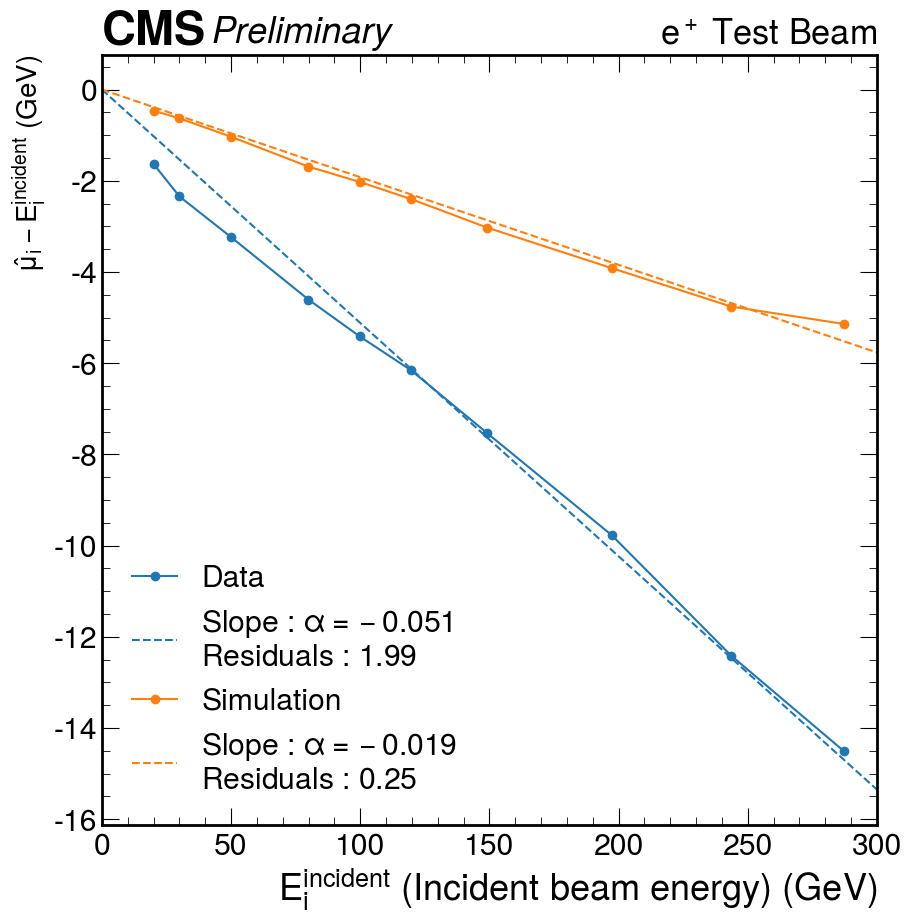

In [38]:
plt.figure()
x, y = makeDiffXY(comp_data.results)
plt.plot(x, y, 'o-', label="Data", color="tab:blue")
propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
plt.plot([0, 300], np.array([0, 300])*propConstant[0], '--', color="tab:blue", 
    label=f"Slope : $\\alpha = {propConstant[0]:.3f}$\nResiduals : ${residuals[0]:.2f}$")

x, y = makeDiffXY(comp_sim.results)
plt.plot(x, y, 'o-', label="Simulation", color="tab:orange")
propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
plt.plot([0, 300], np.array([0, 300])*propConstant[0], '--',  color="tab:orange",
    label=f"Slope : $\\alpha = {propConstant[0]:.3f}$\nResiduals : ${residuals[0]:.2f}$")

plt.xlim(0, 300)
plt.xlabel(r"$E_i^{incident}$ (Incident beam energy) (GeV)")
plt.ylabel(r"$\hat{\mu}_i - E_i^{incident}$ (GeV)", fontsize=20)
hep.cms.text("Preliminary")
hep.cms.lumitext("$e^+$ Test Beam")
plt.legend()

plt.savefig("calibration-plot.pdf", bbox_inches="tight")

/tmp/ipykernel_314929/3347884459.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)


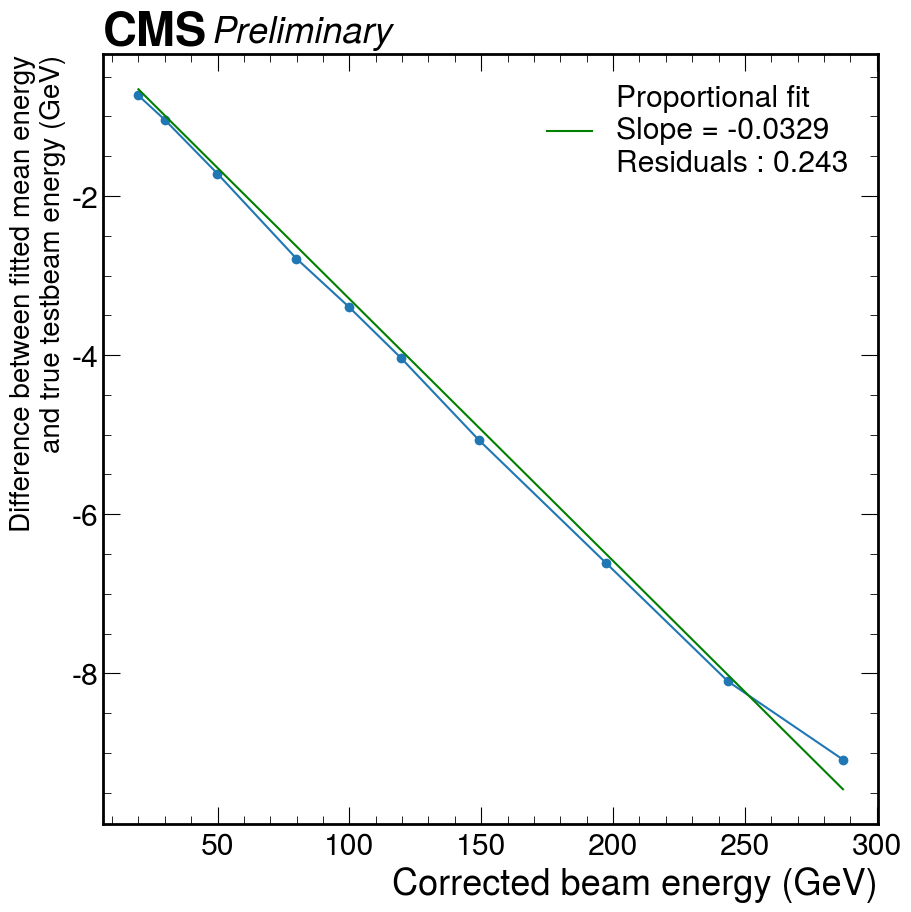

In [20]:
plotDiffToTrueEnergy(comp_sim.results, plotLinearFit=False)